<img src='./img/DataStore_EUMETSAT.png'/>

Copyright (c) 2025 EUMETSAT <br>
License: MIT

<hr>

<a href="./index.ipynb">← Index</a>
<br>
<a href="./1_4_Sentinel3_data_access.ipynb">← Sentinel-3 Data Store access with EUMDAC</a><span style="float:right;"><a href="./1_6_MTG_LI_data_access.ipynb">Accessing MTG LI products →</a>

# Accessing MTG FCI products

### Data used

| Product Description  | Data Store collection ID| Product Navigator |
|:--------------------:|:-----------------------:|:-----------------:|
| FCI Level 1c Normal Resolution Image Data - MTG - 0 degree | EO:EUM:DAT:0662 | [link](https://data.eumetsat.int/product/EO:EUM:DAT:0662) |
| FCI Level 1c High Resolution Image Data - MTG - 0 degree | EO:EUM:DAT:0665 | [link](https://data.eumetsat.int/product/EO:EUM:DAT:0665) |


### Learning outcomes

At the end of this notebook you will know;
* How to refine your **searches** for MTG products in the EUMETSAT Data Store using the `eumdac` API client
* How to **download** products from your refined search results
* How to **download components** of a product
* How to **customise** products using the Data Tailor Web Service

## Selecting and filtering a collection
As usual, we begin by importing our required modules.

In [36]:
import eumdac
import datetime
import shutil
import fnmatch
import requests
import time
import os
import zipfile
import json

Now, we have to authorize with our personal credentials to generate the token.

In [37]:
# Insert your personal key and secret into the single quotes
consumer_key = 'YOUR_CONSUMER_KEY'
consumer_secret = 'YOUR_CONSUMER_SECRET'

credentials = (consumer_key, consumer_secret)

token = eumdac.AccessToken(credentials)

print(f"This token '{token}' expires {token.expiration}")

This token 'cdc2c716-87d9-3c44-9dd3-a402f6c99411' expires 2025-02-25 09:58:46.590037


<div class="alert alert-block alert-success">
<b>NOTE:</b><br />
You can find your personal API credentials here: <a href="https://api.eumetsat.int/api-key/">https://api.eumetsat.int/api-key/</a>
</div>

Let's start by selecting a collection we want to browse and print some useful information about this collection. For more information on determining which collections are available, see the previous tutorial, <a href="./1_Discovering_collections.ipynb">Discovering collections</a>.

In [38]:
datastore = eumdac.DataStore(token)

selected_collection = datastore.get_collection('EO:EUM:DAT:0662')
print(f"{selected_collection} - {selected_collection.title}")
print(f"Description: {selected_collection.abstract}")
print(f"Metadata: {selected_collection.metadata}")
print(f"Search options: {selected_collection.search_options} \n")

selected_collection = datastore.get_collection('EO:EUM:DAT:0665')
print(f"{selected_collection} - {selected_collection.title}")
print(f"Description: {selected_collection.abstract}")
print(f"Metadata: {selected_collection.metadata}")
print(f"Search options: {selected_collection.search_options}")

EO:EUM:DAT:0662 - FCI Level 1c Normal Resolution Image Data - MTG - 0 degree
Description: The rectified (Level 1c) Meteosat FCI full disc image data in normal spatial (FDHSI) resolution. The FCI instrument consists of 16 imaging spectral channels ranging from 0.4 µm to 13.3 µm with the channel at 3.8 µm having an extended dynamic range dedicated to fire monitoring. The spatial resolution is 1km for visible and near-infrared channels and 2 km for infrared channels. FCI Level 1c rectified radiance dataset consists of a set of files that contain the level 1c science data rectified to a reference grid together with the auxiliary data associated with the processing configuration and the quality assessment of the dataset. Level 1c image data here corresponds to initially geolocated and radiometrically pre-processed image data, without full georeferencing and cal/val in spatial and spectral domains applied. The data are ready for further processing and testing, e.g. value chains and initial t

The previous tutorial also showed us how to select a collection and filter it for products of interest using both time and location. As we are using a GEO product for our examples, there is no need to set a bounding box. However, we are going to perform a similar operation using time filtering so that we can set up a download. So, let's run our query to get our product IDs.

In [39]:
# Select a collection
selected_collection = datastore.get_collection('EO:EUM:DAT:0662')

# Set sensing start and end time
start = datetime.datetime(2025, 1, 26, 21, 30)
end = datetime.datetime(2025, 1, 26, 21, 50)

# Retrieve datasets that match our filter
products = selected_collection.search(
    dtstart=start,
    dtend=end)

print(f"{products.total_results} products found:")

for product in products:
    print(product)

2 products found:
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20250126214245_IDPFI_OPE_20250126214007_20250126214928_N__O_0131_0000
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20250126213255_IDPFI_OPE_20250126213007_20250126213924_N__O_0130_0000


We have found some datasets. In the following sections we will look at ways of downloading these.

<div class="alert alert-block alert-success">
<b>NOTE:</b><br />
MTG products follow the WMO file naming convention. You can find more information about this in our User Portal guide: <a href="https://user.eumetsat.int/resources/user-guides/mtg-fci-level-1c-data-guide#ID-Naming-convention">https://user.eumetsat.int/resources/user-guides/mtg-fci-level-1c-data-guide#ID-Naming-convention</a>
</div>

## Download products

Products can be downloaded by providing either their product ID, or a combination of their collection ID and several search parameters. We can download entire products, or specific file components (e.g. metadata only). The following section gives you three **independent** examples.

### Download all products from search

We have found our relevant products. Now we would like to download all of them without having to select every single product. For this we can simply loop over the products and save the products as files in our directory.

In [40]:
for product in products:
    with product.open() as fsrc, \
            open(fsrc.name, mode='wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of product {product} finished.')
    
print('All downloads are finished.')

Download of product W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20250126214245_IDPFI_OPE_20250126214007_20250126214928_N__O_0131_0000 finished.
Download of product W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20250126213255_IDPFI_OPE_20250126213007_20250126213924_N__O_0130_0000 finished.
All downloads are finished.


Perfect, now you downloaded all products based on your search parameters.

### Download a single product
Sometimes, however, we only need one specific product from the collection. For this purpose we can just search for the product in the collection.

In [41]:
single_product = datastore.get_product(
    product_id='W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20250126214245_IDPFI_OPE_20250126214007_20250126214928_N__O_0131_0000',
    collection_id='EO:EUM:DAT:0662')

print(single_product) 

W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20250126214245_IDPFI_OPE_20250126214007_20250126214928_N__O_0131_0000


...and download it as usual:

In [42]:
with single_product.open() as fsrc, open(fsrc.name, mode='wb') as fdst:
    shutil.copyfileobj(fsrc, fdst)

### Download chunks of the products based on coverage
An FCI dataset covers a full repeat cycle and is divided into a series of individual files or 'chunks' which facilitate dissemination. The main bulk of the dataset is a series of chunks that contain the observation data within the repeat cycle. There is also a trailer chunk that contains information applicable to or derived from the complete repeat cycle. Every product consists of around 40 chunks within a full disc repeat cycle.

<div class="alert alert-block alert-success">
<b>NOTE:</b><br />
Find more information about how data chunks are working in our User Portal guide: <a href="https://user.eumetsat.int/resources/user-guides/mtg-fci-level-1c-data-guide#ID-Level-1C-registered-radiance-datasets-structure-and-presentation">https://user.eumetsat.int/resources/user-guides/mtg-fci-level-1c-data-guide#ID-Level-1C-registered-radiance-datasets-structure-and-presentation</a>
</div>

Let's investigate how the chunks of a product can be examined and downloaded. First, we select a specific product using product ID:

In [43]:
product = datastore.get_product(
    product_id='W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20250126214245_IDPFI_OPE_20250126214007_20250126214928_N__O_0131_0000',
    collection_id='EO:EUM:DAT:0662')

print(product)

W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20250126214245_IDPFI_OPE_20250126214007_20250126214928_N__O_0131_0000


Now we can display the product entries. Product entries are all files within a product, e.g. files with the observation data, metadata files and manifests.

In [44]:
for entry in product.entries:
    print(entry)

W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20250126214528_IDPFI_OPE_20250126214112_20250126214212_N__O_0131_0009.nc
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20250126214721_IDPFI_OPE_20250126214416_20250126214456_N__O_0131_0020.nc
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20250126215028_IDPFI_OPE_20250126214755_20250126214842_N__O_0131_0034.nc
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20250126214447_IDPFI_OPE_20250126214023_20250126214105_N__O_0131_0004.nc
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20250126214514_IDPFI_OPE_20250126214050_20250126214146_N__O_0131_0007.nc
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20250126214531_IDPFI_OPE_20250126214129_20250126214221_N__O_0131_0010.nc
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---

If you are interested in a particular geographical area, it makes sense to download not the full product, but the interesting parts of it that covering your area of interest. We can split the full disc into multiple sections with it's corresponding chunks:

<img src='./img/MTG_lacs.png'/>

Additionally, we recommend to download the trailer chunk (chunk 41) as it contains additional information and statistics regarding the whole repeat cycle.

In the code cell below we defined which chunk files are part of which area coverage (plus trailer chunk):

In [45]:
FD = ["_????_00[0-3][0-9].nc", "_????_0040.nc", "*_????_0041.nc"] # Full disc; chunks 01-40 + 41
H1 = ["*_????_000[1-9].nc", "*_????_001[0-9].nc", "*_????_002[0-1].nc", "*_????_0041.nc"] # chunks 01-21 + 41
H2 = ["*_????_002[0-9].nc", "*_????_003[0-9].nc", "*_????_0040.nc", "*_????_0041.nc"] # chunks 20-40 + 41
T1 = ["*_????_000[1-9].nc", "*_????_001[0-6].nc", "*_????_0041.nc"] # chunks 01-16 + 41
T2 = ["*_????_001[3-9].nc", "*_????_002[0-7].nc", "*_????_0041.nc"] # chunks 13-27 + 41
T3 = ["*_????_002[6-9].nc", "*_????_003[0-9].nc", "*_????_0040.nc", "*_????_0041.nc"] # chunks 26-48 + 41
Q1 = ["*_????_000[0-9].nc", "*_????_001[0-3].nc", "*_????_0041.nc"] # chunks 01-13 + 41
Q2 = ["*_????_001[0-9].nc", "*_????_002[0-1].nc", "*_????_0041.nc"] # chunks 10-21 + 41
Q3 = ["*_????_002[0-9].nc", "*_????_0030.nc", "*_????_0041.nc"] # chunks 20-30 + 41
Q4 = ["*_????_0029.nc", "*_????_003[0-9].nc", "*_????_0040.nc", "*_????_0041.nc"] # chunks 29-40 + 41

# This function checks if a product entry is part of the requested coverage
def get_coverage(coverage, filenames):
    chunks = []
    for pattern in coverage:
        for file in filenames:
            if fnmatch.fnmatch(file, pattern):
                chunks.append(file)
    return chunks

<div class="alert alert-block alert-success">
<b>NOTE:</b><br />
Find more information about the different scanning services and local area coverages (LAC) in our User Portal guide: <a href="https://user.eumetsat.int/resources/user-guides/mtg-fci-level-1c-data-guide#ID-Scanning-services">https://user.eumetsat.int/resources/user-guides/mtg-fci-level-1c-data-guide#ID-Scanning-services</a>
</div>

Now we can define the area we are interested in, loop over all product entries and download just the bits that we are interested in.

In [46]:
coverage = T1

for file in get_coverage(Q4, product.entries):
    with product.open(entry=file) as fsrc, \
            open(fsrc.name, mode='wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of file {fsrc.name} finished.')

Download of file W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20250126214935_IDPFI_OPE_20250126214652_20250126214737_N__O_0131_0029.nc finished.
Download of file W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20250126215028_IDPFI_OPE_20250126214755_20250126214842_N__O_0131_0034.nc finished.
Download of file W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20250126215054_IDPFI_OPE_20250126214849_20250126214919_N__O_0131_0038.nc finished.
Download of file W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20250126215028_IDPFI_OPE_20250126214746_20250126214827_N__O_0131_0033.nc finished.
Download of file W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20250126215008_IDPFI_OPE_20250126214720_20250126214755_N__O_0131_0031.nc finished.
Download of file W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4

### Identifying MTG FCI Chunks for a Specific Region of Interest (ROI)

For some use-cases the provided coverage areas dont offer enough detalisation, and a user might be interested in downloading only those data chunks that match their region of interest. Further steps will show users how identify Meteosat Third Generation (MTG) data chunks they need to download for a given Region Of Interest (ROI).


### Define your Region of Interest (ROI):
Specify the geographic bounds using latitude and longitude coordinates to specify the geographic region you are interested in.



In [47]:
# Define ROI bounds (latitude and longitude bounding bbox)
user_roi = {
    "lat_min": 0,
    "lat_max": 15,
    "lon_min": 15,
    "lon_max": 30
}
print(f"Defined ROI: {user_roi}")


Defined ROI: {'lat_min': 0, 'lat_max': 15, 'lon_min': 15, 'lon_max': 30}


Now we want to know what is the MTG FCI data chunks cover and match that to the region of interest (ROI). To do this we need to perform coordinate converstion to know the geographical extent for each of the data chunks.

MTG FCI data uses a reference grid that defines the geo-referenced position of the image pixel centroids at level 1c in a normalised geostationary projection. The transformation from satellite viewing angles (λs,fs) to geographical coordinates (lon, lat) is done using a inverse projection function. You can get more familiar with details about how the FCI data in the MTG User Guide: https://user.eumetsat.int/resources/user-guides/mtg-fci-level-1c-data-guide#ID-FCI 

For sake of convenience and to save on computer resource consumption we will be using a pre-processed chunk map file (FCI_chunks.wkt) that is added to this code repositor. Using a pre-processed chunk map helps us avoid performing the coordinate conversion operation, which in our example file was done for every second pixel. If you need the more exact data chunk extents mapping, then we strongly suggest to set up and run your own corrdinate conversion processing following the information in service and data user guides.

In [48]:
import os
from shapely.wkt import loads
from shapely.geometry import Polygon

# Define file path to precomputed FCI data chunk map in WKT format 
wkt_file_path = "FCI_chunks.wkt"  

if not os.path.exists(wkt_file_path):
    raise FileNotFoundError(f"File {wkt_file_path} not found. Make sure it is in the repository.")

# Load WKT chunk footprints
with open(wkt_file_path, "r") as file:
    wkt_data = file.readlines()

# Parse chunk polygons from WKT
chunk_polygons = {}
for line in wkt_data:
    chunk_id, wkt_poly = line.strip().split(',', 1)  # Extract chunk ID
    chunk_polygons[chunk_id] = loads(wkt_poly)  

print(f"Loaded {len(chunk_polygons)} chunk footprints from WKT file.")

Loaded 40 chunk footprints from WKT file.


### Match ROI to Chunks:
Now we can find which data chunks intersect with your defined ROI. Running the next cell will print the corresponding chunk ID's.


In [49]:
# Convert user ROI to a Shapely Polygon
roi_polygon = Polygon([
    (user_roi["lon_min"], user_roi["lat_min"]),
    (user_roi["lon_min"], user_roi["lat_max"]),
    (user_roi["lon_max"], user_roi["lat_max"]),
    (user_roi["lon_max"], user_roi["lat_min"])
])

# Find chunks that intersect with ROI
relevant_chunks = []
for chunk_id, chunk_poly in chunk_polygons.items():
    if roi_polygon.intersects(chunk_poly):
        relevant_chunks.append(chunk_id)

print(f"Found {len(relevant_chunks)} chunks intersecting the ROI: {relevant_chunks}")

Found 6 chunks intersecting the ROI: ['0021', '0022', '0023', '0024', '0025', '0026']


### Plot:
Let's display the ROI and MTG data chunks on a map to see the intersect.


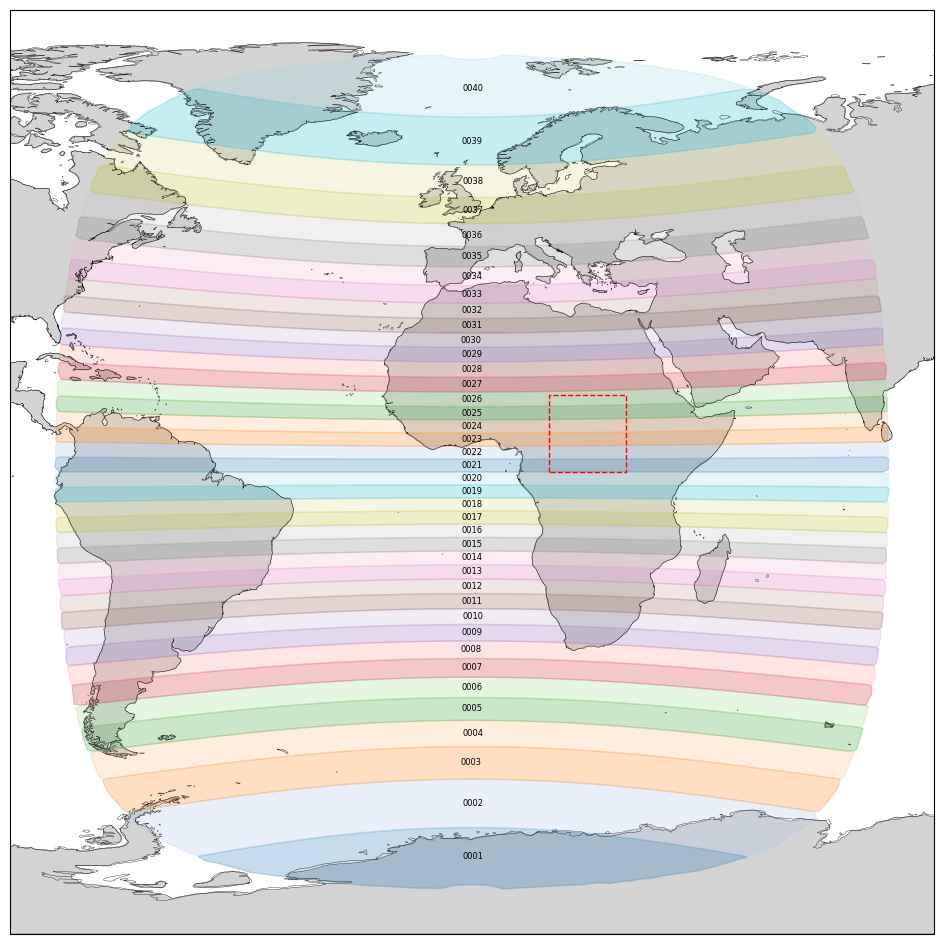

In [50]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import LineString

# Convert chunk polygons to a GeoDataFrame
gdf_chunks = gpd.GeoDataFrame({"chunk_id": list(chunk_polygons.keys()), "geometry": list(chunk_polygons.values())}, crs="EPSG:4326")

# Plot setup
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-90, 90, -90, 90])
ax.coastlines("50m", linewidth=0.25)
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", linewidth=0.25)

# Plot chunks with labels
for i, row in gdf_chunks.iterrows():
    chunk_id, chunk_poly = row["chunk_id"], row["geometry"]
    if not chunk_poly.is_valid: continue
    ax.fill(*chunk_poly.exterior.xy, color=plt.cm.tab20.colors[i % 20], alpha=0.25, transform=ccrs.PlateCarree())

    # Label position inside polygon
    center_x = (chunk_poly.bounds[0] + chunk_poly.bounds[2]) / 2 
    vertical_line = LineString([(center_x, chunk_poly.bounds[1]), (center_x, chunk_poly.bounds[3])])
    label_y = vertical_line.intersection(chunk_poly).centroid.y
    ax.text(center_x, label_y, chunk_id, fontsize=6, transform=ccrs.PlateCarree(), ha="center", va="center")

# Highlight ROI
ax.plot(*roi_polygon.exterior.xy, color="red", linewidth=1, linestyle="dashed", transform=ccrs.PlateCarree())
plt.title("MTG Chunk coverage extent and user ROI")
plt.show()


### Download matching Chunks:
Now we can download the chunks that match the specified ROI.
We also want to filter that data using a time period for search:

In [51]:
dtstart = datetime.datetime(2024, 11, 1, 11, 50)
dtend   = datetime.datetime(2024, 11, 1, 12, 0)

print(f"Time window: from {dtstart} to {dtend}.")


Time window: from 2024-11-01 11:50:00 to 2024-11-01 12:00:00.


Now we can combine the filters and download data based on the selected time and ROI. Additionally, the trailer chunk for each relevant timestep will be added to the downloads, ensuring further dataset usability.

In [52]:
def download_chunks_in_time_window(selected_collection, dtstart, dtend, chunk_ids):
    """
    Search for products in the given time window, download relevant .nc entries and trailer chunk (0041).
    """

    # Always ensure trailer chunk "0041" is included
    chunk_ids.append("0041")

    chunk_patterns = [f"_{cid}.nc" for cid in chunk_ids]

    # Products in time window
    products = selected_collection.search(dtstart=dtstart, dtend=dtend)
    print(f"Found {len(products)} matching timestep(s).")

    # Filter relevant entries
    for product in products:
        for entry in product.entries:
            if any(pattern in entry for pattern in chunk_patterns):
                try:
                    with product.open(entry=entry) as fsrc:
                        local_filename = os.path.basename(fsrc.name)
                        print(f"Downloading file {local_filename}...")
                        with open(local_filename, 'wb') as fdst:
                            shutil.copyfileobj(fsrc, fdst)
                        print(f"Saved file {local_filename}")
                except Exception as e:
                    print(f"Error downloading {entry}: {e}")

# Run the function
download_chunks_in_time_window(
    selected_collection=selected_collection, dtstart=dtstart, dtend=dtend, chunk_ids=relevant_chunks)

Found 1 matching timestep(s).
Saved file W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20241101115751_IDPFI_OPE_20241101115506_20241101115545_N__C_0072_0023.nc
Saved file W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20241101115751_IDPFI_OPE_20241101115446_20241101115525_N__C_0072_0022.nc
Saved file W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20241101115806_IDPFI_OPE_20241101115525_20241101115555_N__C_0072_0024.nc
Saved file W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20241101115820_IDPFI_OPE_20241101115545_20241101115614_N__C_0072_0025.nc
Saved file W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-TRAIL---NC4E_C_EUMT_20241101115301_IDPFI_OPE_20241101115007_20241101115924_N__C_0072_0041.nc
Saved file W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20241101115737_IDPFI_OPE_20241101115436_202411

### Save the example FCI data Chunk map locally
If you need to save the chunk map as a file, you can grab it directly from the repo or run the following cell. If it is already on your device, then nothing else will be downloaded.


In [53]:
output_file = "mtg_chunk_map.wkt"

if not os.path.exists(output_file):
    with open(output_file, "w") as f:
        for chunk_id, chunk_poly in chunk_polygons.items():
            f.write(f"{chunk_id},{chunk_poly.wkt}\n")
    print(f"Chunk map WKT saved as {output_file}.")
else:
    print(f"Chunk map WKT already exists locally as {output_file}.")

Chunk map WKT already exists locally as mtg_chunk_map.wkt.


## Customise products

The Data Tailor is a product customisation toolbox designed to enable users to tailor satellite data to their specific needs. It offers the ability to subset and aggregate data products across space and time, filter layers, generate quick looks, reproject data onto new coordinate reference systems, and reformat data into widely used Geographic Information System (GIS) formats such as netCDF and GeoTIFF, as well as image formats like JPEG and PNG. The Data Tailor can currently customize data from various satellite collections, including MTG FCI.

In [54]:
# Create datatailor object with with your token
datatailor = eumdac.DataTailor(token)

You can now select and FCI collection, set a start and end time and select a product within the dates.

In [55]:
# Select an FCI collection, eg "FCI Level 1c High Resolution Image Data - MTG - 0 degree" - "EO:EUM:DAT:0665"
selected_collection = datastore.get_collection('EO:EUM:DAT:0665')
 
# Set sensing start and end time
start = datetime.datetime(2025, 1, 26, 19, 30)
end = datetime.datetime(2025, 1, 26, 23, 30)
 
# Retrieve latest product that matches the filter
product = selected_collection.search(
    dtstart=start,
    dtend=end).first()

You should define a chain for a Data Tailor customisation.

In [56]:
# Define the chain configuration
chain = eumdac.tailor_models.Chain(
    product='FCIL1HRFI',
    format='geotiff',
    filter={"bands" : ["ir_38_hr_effective_radiance", "ir_38_hr_effective_radiance"]},
    projection='geographic',
    roi='western_europe'
)

After defining the chain, we can start the customisation and track its status.

In [57]:
# Send the customisation to Data Tailor Web Services
customisation = datatailor.new_customisation(product, chain=chain)
 
status = customisation.status
sleep_time = 10 # seconds
 
# Customisation loop to read current status of the customisation
print("Starting customisation process...")
while status:
    # Get the status of the ongoing customisation
    status = customisation.status
    if "DONE" in status:
        print(f"Customisation {customisation._id} is successfully completed.")
        break
    elif status in ["ERROR", "FAILED", "DELETED", "KILLED", "INACTIVE"]:
        print(f"Customisation {customisation._id} was unsuccessful. Customisation log is printed.\n")
        print(customisation.logfile)
        break
    elif "QUEUED" in status:
        print(f"Customisation {customisation._id} is queued.")
    elif "RUNNING" in status:
        print(f"Customisation {customisation._id} is running.")
    time.sleep(sleep_time)

Starting customisation process...
Customisation 3e56e716 is queued.
Customisation 3e56e716 is running.
Customisation 3e56e716 is running.
Customisation 3e56e716 is running.
Customisation 3e56e716 is running.
Customisation 3e56e716 is running.
Customisation 3e56e716 is running.
Customisation 3e56e716 is successfully completed.


After the customisation is DONE, you can download the customised product from the Data Tailor Web Services

In [58]:
# Download the customised product
print("Starting download of customised products...")
for product in customisation.outputs:
    print(f"Downloading product: {product}")
    with customisation.stream_output(product) as source_file, open(source_file.name, 'wb') as destination_file:
        shutil.copyfileobj(source_file, destination_file)
    print(f"Product {product} downloaded successfully.")

Starting download of customised products...
Product FCIL1HRFI-FPC-3e56e716/FCIL1HRFI_20250126T232729Z_20250126T232919Z_epct_3e56e716_FPC.tif downloaded successfully.


<a href="./index.ipynb">← Index</a>
<br>
<a href="./1_4_Sentinel3_data_access.ipynb">← Sentinel-3 Data Store access with EUMDAC</a><span style="float:right;"><a href="./1_6_MTG_LI_data_access.ipynb">Accessing MTG LI Level 2 products →</a>

<hr>

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE.TXT">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/data-services/eumdac_data_store">View on GitLab</a> | <a href="https://classroom.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact</a></span></p>